## Lab 5: Machine learning in Python

**Objectives:**
   * Engineer some features for better prediction of California house prices 
   * Train a machine learning model using <code>scikit-learn</code>
   * Evaluate our machine learning model

## Feature engineering

The most important part of data science is generating new features that have predictive power. We just used the default variables for predicting house prices in the lecture but there are other factors that may be useful.

For example, we often have **geolocation data**, which could be very useful for house price prediction task. In this demo we will engineer some new features to improve the accuracy of our house price prediction model.

As a recap, these were the mean-sqaured-errors from the lecture demo:

* Multiple linear regression: $64,374


* Decision Tree: $82,290


* RandomForests: $60,264



In [18]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

np.random.seed(42)

In [19]:
# Import data
df = pd.read_csv('./data/seattle_house_prices.csv')

In [20]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat']))
gdf = gdf.set_crs(4326, allow_override=True)

# Reproject everything to UTM 10N (EPSG:32610)
gdf_utm = gdf.to_crs('EPSG:32610')

In [21]:
# Compute correlation matrix
corr_matrix = gdf_utm.corr()

# Display absolute house value correlations
corr_matrix["price"].abs().sort_values(ascending= False)

price          1.000000
sqft_living    0.702296
bathrooms      0.524395
bedrooms       0.315804
lat            0.308082
sqft_lot       0.090125
yr_built       0.052453
long           0.020092
Name: price, dtype: float64

***********
## Question 1 (10 points): 

To start, make a **new** `jupyter notebook` called `lab5_submission.ipynb` and work through the following tasks. 

The first task is answer the following questions using some of the methods we have covered in the lecture/demo. 

* How many houses are in this dataset?
* How many **features** are there for predicting house price? 
* Are there any null values in this dataset?
* Which three variables are best correlated with house price (include correlation coefficients)?
* Which three variables are least correlated with house price (include correlation coefficients)?

In [22]:
# Houses in dataset
print("There are %i houses in the dataset." %len(gdf_utm['price']))

There are 19451 houses in the dataset.


In [23]:
# Features available in dataset
print("There are %i features (or independent variables) available for predicting house princes." %(len(gdf_utm.columns)-2))

There are 7 features (or independent variables) available for predicting house princes.


In [24]:
# Number of null values in dataset
print("There are %i null values in this dataset." %(gdf_utm.isna().sum().sum()))

There are 0 null values in this dataset.


In [25]:
# Highest correlation
var_high_corr = (corr_matrix["price"].abs().sort_values(ascending= False)).index[1:4]
high_corr_val = (corr_matrix["price"].abs().sort_values(ascending= False)).values[1:4]

print("The three best correlated features are %s, %s, and %s, with correlations of %.2f, %.2f, %.2f, repsectively." %(*var_high_corr, *high_corr_val))

The three best correlated features are sqft_living, bathrooms, and bedrooms, with correlations of 0.70, 0.52, 0.32, repsectively.


In [26]:
# Lowest correlation
var_high_corr = (corr_matrix["price"].abs().sort_values(ascending= False)).index[-3:]
high_corr_val = (corr_matrix["price"].abs().sort_values(ascending= False)).values[-3:]

print("The three least correlated features are %s, %s, and %s, with correlations of %.2f, %.2f, %.2f, repsectively." %(*var_high_corr, *high_corr_val))

The three least correlated features are sqft_lot, yr_built, and long, with correlations of 0.09, 0.05, 0.02, repsectively.


*******

## Question 2 (30 points):

* Produce a model to predict house prices. You are welcome to generate new features, scale the data, and split the data into training/testing (i.e. `train_test_split`) in any way you like. 


* Evaluate your model's accuracy by predicting a test dataset, for example:

`predictions = forest_reg.predict(X_test)
final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)`


* Push your `lab5_submission.ipynb` to GitHub and submit a `.pdf` version to Canvas 



* On **Monday** the instructor and TA will provide an **unseen set of houses** which students will use to repeat their accuracy evaluation. The best models (i.e. lowest RMSE) will win prizes. 


* We will evaluate the models using a simple `mean-squared-error` as follows:

`mse = mean_squared_error(y_test , predictions)
rmse = np.sqrt(final_mse)`

In [27]:
# Define feature list
feature_list =  ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built', 'lat', 'long']

# Define features and labels 
X = gdf_utm[feature_list]
y = gdf_utm['price']

# Standarize data
scaler = StandardScaler()  
scaler_ = scaler.fit(X)
X_scaled = scaler_.transform(X)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [28]:
# Define model
forest_reg = RandomForestRegressor(n_jobs=-1,  oob_score=True, random_state=42)

# Fit model
forest_reg.fit(X_train, y_train)

def rmse(y_pred,y):
    return np.sqrt(((y_pred-y)**2).mean())

rmse_train = rmse(forest_reg.predict(X_train),y_train)
rmse_test = rmse(forest_reg.predict(X_test),y_test)
train_score = forest_reg.score(X_train,y_train)
test_score = forest_reg.score(X_test,y_test)
oob_score = forest_reg.oob_score_

print("""
RMSE_train: %f\n
RMSE_test: %f\n
train_score: %f\n
test_score: %f\n
oob_score: %f
""" %(rmse_train, rmse_test, train_score, test_score, oob_score))


RMSE_train: 58917.329253

RMSE_test: 153340.054787

train_score: 0.974027

test_score: 0.834690

oob_score: 0.816330



The hyper-paramterizing has been run, but is now commented out, so that the conversion to PDF doesn't take a long time. The found parameters can be found two cells after this text, in the input paramters for the forest_reg_hp model. The exception is max_depth, which has changed in the code, but I don't feel like running the hyper-parametrization again.

In [29]:
# # hyper parametrize: n_estimators, min_samples_leaf, max_features
# n_estimators = [int(x) for x in np.arange(start = 10, stop = 500, step = 10)]
# max_features = [0.25, 0.5, 0.75, 1, 'auto', 'sqrt','log2']
# min_samples_leaf = [1, 2, 3, 4, 5, 6, 7]
# max_depth = [int(x) for x in np.arange(start = 1, stop = 300, step = 10)]
# bootstrap = [True, False]
# param_dict = {'n_estimators': n_estimators, 'max_features': max_features, 'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap, 'max_depth' : max_depth}

# # First create the base model to tune
# forest_reg_hp = RandomForestRegressor()
# # Fit the random search model
# forest_reg_random = HalvingGridSearchCV(estimator=forest_reg_hp, param_grid=param_dict, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
# forest_reg_random.fit(X_train, y_train)
# forest_reg_random.best_params_

In [30]:
# Define model
forest_reg_hp = RandomForestRegressor(n_estimators=170, max_depth=200, min_samples_leaf=1, n_jobs=-1, oob_score=True, random_state=42)

# Fit model
forest_reg_hp.fit(X_train, y_train)

rmse_train_hp = rmse(forest_reg_hp.predict(X_train),y_train)
rmse_test_hp = rmse(forest_reg_hp.predict(X_test),y_test)
train_score_hp = forest_reg_hp.score(X_train,y_train)
test_score_hp = forest_reg_hp.score(X_test,y_test)
oob_score_hp = forest_reg_hp.oob_score_

print("""
RMSE_train: %f\n
RMSE_test: %f\n
train_score: %f\n
test_score: %f\n
oob_score: %f
""" %(rmse_train_hp, rmse_test_hp, train_score_hp, test_score_hp, oob_score_hp))


RMSE_train: 58388.492486

RMSE_test: 153220.218147

train_score: 0.974491

test_score: 0.834949

oob_score: 0.816007



In [31]:
# display effects of hyperfitting

print("""
RMSE_train dif (negative better): %f
RMSE_test dif (negative better): %f\n
train_score dif (positive better): %f\n
test_score dif (positive better): %f\n
oob_score dif (positive better): %f
""" %(rmse_train_hp-rmse_train, rmse_test_hp-rmse_test, train_score_hp-train_score, test_score_hp-test_score, oob_score_hp-oob_score))


RMSE_train dif (negative better): -528.836767
RMSE_test dif (negative better): -119.836640

train_score dif (positive better): 0.000464

test_score dif (positive better): 0.000258

oob_score dif (positive better): -0.000323



I tried to hyper-parametrize my model rather than add new features. The process has technically worked, but only by a little. The RMSE for the test data came back $119.84 smaller than the base model.

*********

## Task 1 (10 points):

Submit a project idea to the `#final-projects` channel on **Slack**. See: https://github.com/JohnnyRyan1/geospatial-data-science/blob/master/labs/lab5/project_ideas_task.md for more details.


## Remember to submit your answers to Questions 1 and 2 and complete Task 1 **by Friday 11:59pm**

## Model evaluation

In [32]:
# Predict test labels predictions
data_eval = pd.read_csv("./data/0_housing_evaluation_data.csv")

egdf = gpd.GeoDataFrame(data_eval, geometry=gpd.points_from_xy(data_eval['long'], data_eval['lat']))
egdf = egdf.set_crs(4326, allow_override=True)

# Reproject everything to UTM 10N (EPSG:32610)
egdf_utm = egdf.to_crs('EPSG:32610')

feature_list =  ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built', 'lat', 'long']
X_eval = egdf_utm[feature_list]
y_eval = egdf_utm['price']

# Standarize data
X_eval_z = scaler_.transform(X_eval)

housing_test_pred = forest_reg_hp.predict(X_eval_z)

In [33]:
# Compute mean-squared-error
final_mse = mean_squared_error(y_eval, housing_test_pred)
final_rmse = np.sqrt(final_mse)
print("Your model RMSE: USD %.2f" %final_rmse)


Your model RMSE: USD 151614.68


(0.0, 1000000.0)

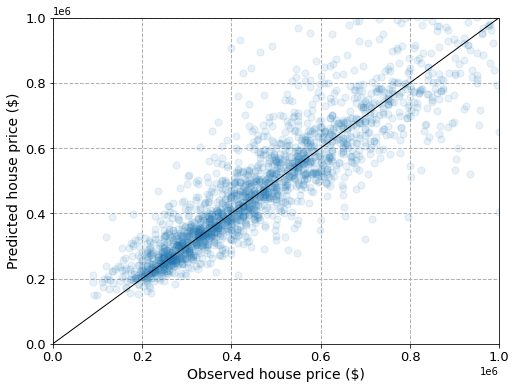

In [34]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_eval, housing_test_pred, alpha=0.1, s=50, zorder=2)
ax.plot([0,1000000], [0, 1000000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted house price ($)', fontsize=14)
ax.set_xlabel('Observed house price ($)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,1000000)
ax.set_xlim(0,1000000)

# 151614.68